In [1]:
# lib
# ! pip install albumentations

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import torch.nn.functional as F

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# load
class CamVidDataset(torch.utils.data.Dataset):
    """
    CamVid Dataset: read images, augmentation and preprocessing transformation
    args:
        images_dir(str): path to images folder
        masks_dir(str): path to segmentation masks folder
        class_values(list): values of classees to exract from segmentation mask
        augmentation(albumentations.Compose): data transformation pipeline(flip, scale)
        preprocessing(albumentations.Compose): data preprocessing(noralization, shape manipulation)
    """
    def __init__(self, images_dir, masks_dir):
        self.transform = A.Compose([
            A.Resize(256, 256),
            # A.HorizontalFlip(),  # x-axis
            # A.VerticalFlip(),  # y-axis
            A.Normalize(),  # normalization: ?range(0-256)
            ToTensorV2(),
        ])
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, mask_id.split('.')[0]+'_L'+'.png') for mask_id in self.ids]
        
    def __getitem__(self, i):
        # read data
        image = np.array(Image.open(self.images_fps[i]).convert('RGB'))
        mask = np.array(Image.open(self.masks_fps[i]).convert('RGB'))
        image = self.transform(image=image, mask=mask)
        return image['image'], image['mask'][:,:,0]
    
    def __len__(self):
        return len(self.ids)

x_train_dir = os.path.join('/kaggle/input/camvid/CamVid/train')
y_train_dir = os.path.join('/kaggle/input/camvid/CamVid/train_labels')
x_valid_dir = os.path.join('/kaggle/input/camvid/CamVid/val')
y_valid_dir = os.path.join('/kaggle/input/camvid/CamVid/val_labels')

train_dataset = CamVidDataset(x_train_dir, y_train_dir)
valid_dataset = CamVidDataset(x_valid_dir, y_valid_dir)

train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=True)
# (org)image_size: torch.Size([8, 3, 720, 960]), mask_size: torch.Size([8, 720, 960])

In [3]:
# net
# kernel: 3*3, deep supervision:1*1conv+sigmoid

class Sampling(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Sampling, self).__init__()
        self.sample = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, 1, 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        
    def forward(self, x):
        """
        : param x: input
        : return: out(dense block)
        """
        out = self.sample(x)    
        return out
    
class UNetpp(nn.Module):
    def __init__(self):
        super(UNetpp, self).__init__()
        # channels = [64, 128, 256, 512, 1024]
        
        # downSampleBlock
        self.b0_0 = Sampling(3, 64)  # 3-64-64
        self.b1_0 = Sampling(64, 128)  # 64-128-128
        self.b2_0 = Sampling(128, 256)  # 128-256-256
        self.b3_0 = Sampling(256, 512)  # 256-512-512
        self.b4_0 = Sampling(512, 1024)  # 512-1024-1024
        
        # upSampleBlock
        self.b0_1 = Sampling(192, 64)  # (1*channels[0]+channels[1], channels[0])
        
        self.b1_1 = Sampling(384, 128)  # (1*channels[1]+channels[2], channels[1])
        self.b0_2 = Sampling(256, 64)  # (2*channels[0]+channels[1], channels[0])
        
        self.b2_1 = Sampling(768, 256)  # (1*channels[2]+channels[3], channels[2])
        self.b1_2 = Sampling(512, 128)  # (2*channels[1]+channels[2], channels[1])
        self.b0_3 = Sampling(320, 64)  # (3*channels[0]+channels[1], channels[0])
        
        self.b3_1 = Sampling(1536, 512)  # (1*channels[3]+channels[4], channels[3])
        self.b2_2 = Sampling(1024, 256)  # (2*channels[2]+channels[3], channels[2])
        self.b1_3 = Sampling(640, 128)  # (3*channels[1]+channels[2], channels[1])
        self.b0_4 = Sampling(384, 64)  # (4*channels[0]+channels[1], channels[0])
        
        # downSample
        self.ds = nn.MaxPool2d(2, 2)
        
        # upSample
        self.us = nn.Upsample(scale_factor=2, mode='bilinear')
        
        # segmentation
        self.so = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1,
                      kernel_size=1, stride=1, padding=0),  # 64-1
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        # dense block
        x0_0 = self.b0_0(x)  # 3-64-64
        
        x1_0 = self.b1_0(self.ds(x0_0))  # 64-128-128
        x0_1 = self.b0_1(torch.cat([x0_0, self.us(x1_0)], dim=1))
        
        x2_0 = self.b2_0(self.ds(x1_0))
        x1_1 = self.b1_1(torch.cat([x1_0, self.us(x2_0)], dim=1))
        x0_2 = self.b0_2(torch.cat([x0_0, x0_1, self.us(x1_1)], dim=1))
        
        x3_0 = self.b3_0(self.ds(x2_0))
        x2_1 = self.b2_1(torch.cat([x2_0, self.us(x3_0)], dim=1))
        x1_2 = self.b1_2(torch.cat([x1_0, x1_1, self.us(x2_1)], dim=1))
        x0_3 = self.b0_3(torch.cat([x0_0, x0_1, x0_2, self.us(x1_2)], dim=1))
        
        x4_0 = self.b4_0(self.ds(x3_0))
        x3_1 = self.b3_1(torch.cat([x3_0, self.us(x4_0)], dim=1))
        x2_2 = self.b2_2(torch.cat([x2_0, x2_1, self.us(x3_1)], dim=1))
        x1_3 = self.b1_3(torch.cat([x1_0, x1_1, x1_2, self.us(x2_2)], dim=1))
        x0_4 = self.b0_4(torch.cat([x0_0, x0_1, x0_2, x0_3, self.us(x1_3)], dim=1))
        
        out4 = self.so(x0_4)
        return out4

In [4]:
# loss
class DiceBCELoss(nn.Module):
    # without loss descend
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        # BCEWithLogitsLoss: sigmoid+BCELoss
        self.bce = nn.BCELoss()
        
    def forward(self, inputs, targets, smooth=1):
        targets = torch.sigmoid(targets)
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        # print(targets)
        intersection = (inputs*targets).sum()
        union = inputs.sum() + (targets.sum())
        dice_loss = 1 - ((2*intersection+smooth)/(union+smooth))
        bce_loss = self.bce(inputs, targets)
        loss = dice_loss + bce_loss
        # print(dice_loss, bce_loss, loss)
        return loss

class IoU(nn.Module):
    def __init__(self):
        super(IoU, self).__init__()
        
    def forward(self, inputs, targets, smooth=0.1, threshold=256*0.3):
        # flatten label and prediction
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tempinputs = inputs.detach().cpu()
        temptargets = targets.detach().cpu()
        
        temptargets[np.nonzero(temptargets<threshold)] = 0.0
        temptargets[np.nonzero(temptargets>=threshold)] = 1.0
        # print(tempinputs,temptargets)
        intersection = (tempinputs*temptargets).sum()
        union = tempinputs.sum() + temptargets.sum()
        iou = (intersection+smooth)/(union-intersection+smooth)
        # print(intersection, union, iou)
        return iou

In [5]:
# train, test
def trainer(model, train_loader, valid_loader,
            criterion, optimizer, iou, epochs):
    
    loss_hist, train_hist, valid_hist = [],[],[]
    patience, best_acc, stale = 7, 0, 0
    for epoch in range(epochs):
        print('epoch{}/{}'.format(epoch+1, epochs))
        model.train()
        losses, train_iou, valid_iou = [],[],[]
        for image, mask in train_loader:
            image = image.to(device, dtype=torch.float)
            mask = mask.to(device, dtype=torch.float)
            pred = model.forward(image)
            
            trainpiou = iou(pred,mask)
            loss = criterion(pred, mask)
            
            losses.append(loss.item())
            train_iou.append(trainpiou.detach().cpu())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            for image, mask in valid_loader:
                image = image.to(device)
                mask = mask.to(device)
                pred = model.forward(image)
                validpiou = iou(pred, mask)
            valid_iou.append(validpiou.detach().cpu())
        
        loss_hist.append(np.mean(losses))
        train_hist.append(np.mean(train_iou))
        valid_hist.append(np.mean(valid_iou))
        print('loss:{}'.format(loss_hist[-1]))
        print('Train Accuracy:{}'.format(train_hist[-1]))
        print('Validation Accuracy:{}'.format(valid_hist[-1]))
        
        if valid_hist[-1] > best_acc:
            print(f'Best model found at epoch {epoch+1}, saving model')
            torch.save(model.state_dict(), 'segbrain_unetpp.pt')
            best_acc = valid_hist[-1]
            stale = 0
        else:
            stale += 1
            if stale > patience:
                print(f'No improvment {patience} consecutive epochs, break.')
                break
            
    return loss_hist, train_hist, valid_hist


def plot_model_hist(train_hist, valid_hist, loss_hist):
    x = np.arange(len(train_hist))
    
    fig = plt.figure(figsize=(10,6))
    plt.plot(x, train_hist, label='train_dice')
    plt.plot(x, valid_hist, label='valid_dice')
    plt.plot(x, loss_hist, label='train_loss')
    
    plt.title('unetplusplus', fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel('Epoch')
    plt.ylabel('Dice/Loss')
    
    plt.show()

epoch1/17
loss:0.2902942283733471
Train Accuracy:0.7766668200492859
Validation Accuracy:0.7850481271743774
Best model found at epoch 1, saving model
epoch2/17
loss:0.21571070318286484
Train Accuracy:0.8095434308052063
Validation Accuracy:0.8062978386878967
Best model found at epoch 2, saving model
epoch3/17
loss:0.20280595697663925
Train Accuracy:0.8141303658485413
Validation Accuracy:0.7939499616622925
epoch4/17
loss:0.19637567388850288
Train Accuracy:0.8182141780853271
Validation Accuracy:0.790506899356842
epoch5/17
loss:0.18620343335174225
Train Accuracy:0.8240236043930054
Validation Accuracy:0.8192110657691956
Best model found at epoch 5, saving model
epoch6/17
loss:0.18101063894258962
Train Accuracy:0.8273621201515198
Validation Accuracy:0.8009823560714722
epoch7/17
loss:0.18074284342897906
Train Accuracy:0.8278510570526123
Validation Accuracy:0.790879487991333
epoch8/17
loss:0.1762386507077797
Train Accuracy:0.8304067850112915
Validation Accuracy:0.849863588809967
Best model foun

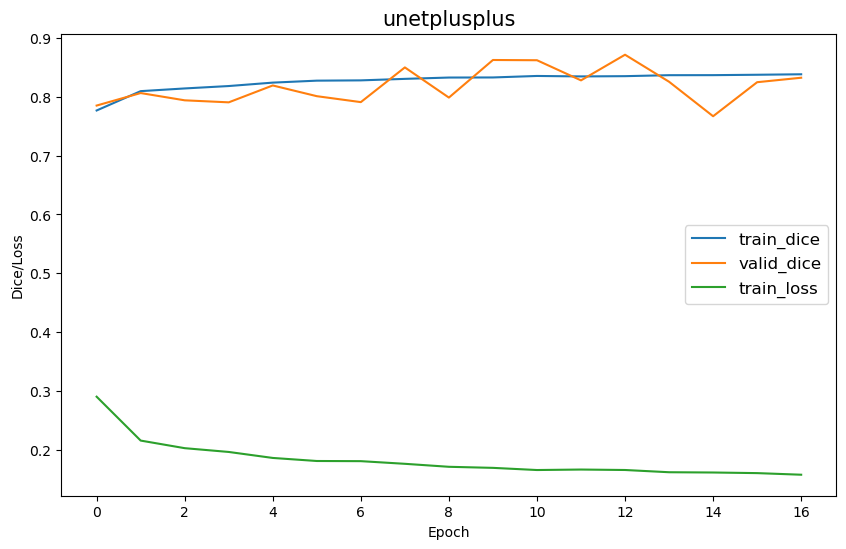

In [6]:
# run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
model = UNetpp().to(device)
criterion = DiceBCELoss()
iou = IoU()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 17

loss_hist, train_hist, valid_hist = trainer(model, train_loader, valid_loader, criterion, optimizer, iou,epochs)
plot_model_hist(train_hist, valid_hist, loss_hist)